In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# 프로젝트 개요
- 강의명 : 2022년 K-디지털 직업훈련(Training) 사업 
- AI데=이터플랫폼을 활용한 빅데이터 분석전문가 과정
- 교과목명 : 빅데이터 분석 및 시각화, AI개발 기초, 인공지능 프로그래밍
- 프로젝트 주제 : Spaceship Titanic 데이터를 활용한 탑승유무 분류모형 개발
- 프로젝트 마감일 : 2022년 4월 12일 화요일
- 수강생명 : 김영재

# reference:https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide

# Step 1. 라이브러리 및 데이터 불러오기
- 본 프로젝트 수행을 위한 필수 라이브러리를 불러온다. 

In [2]:
# 데이터 가공 
import numpy as np 
import pandas as pd 

print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)

# 데이터 시각화
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns 
print("matplotlib version:", matplotlib.__version__)
print("seaborn version:", sns.__version__)

#데이터 전처리




numpy version: 1.20.3
pandas version: 1.3.5
matplotlib version: 3.5.1
seaborn version: 0.11.2


In [3]:
train_data = pd.read_csv("../input/spaceship-titanic/train.csv")
test_data = pd.read_csv("../input/spaceship-titanic/test.csv")
sample_submission = pd.read_csv("../input/spaceship-titanic/sample_submission.csv")

train_data.shape, test_data.shape, sample_submission.shape

((8693, 14), (4277, 13), (4277, 2))

# 컬럼별 결측치 퍼센트 확인하기

In [4]:
missing=pd.DataFrame(train_data.isnull().sum().sort_values(),columns=['sum_missing'])
missing['percetage_null']=missing['sum_missing']/train_data.shape[0]*100
missing

,sum_missing,percetage_null
PassengerId,0,0.000000
Transported,0,0.000000
Age,179,2.059128
RoomService,181,2.082135
Destination,182,2.093639
FoodCourt,183,2.105142
Spa,183,2.105142
VRDeck,188,2.162660
Cabin,199,2.289198
Name,200,2.300702


# 숫자로 되어있는 데이터들만 모아놓기

In [5]:
num_data=train_data.select_dtypes(include='number')
num_data

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,39.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0
4,16.0,303.0,70.0,151.0,565.0,2.0
...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0
8689,18.0,0.0,0.0,0.0,0.0,0.0
8690,26.0,0.0,0.0,1872.0,1.0,0.0
8691,32.0,0.0,1049.0,0.0,353.0,3235.0


# nunique () unique 한 변수의 개수를 추출해주는 메소드

In [6]:
train_data.nunique()   # 변수들이 passenger id 처럼 의미없는 값으로 되어 있는지 알 수 있음

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

####  종속변수의 비율 확인하여 주기.

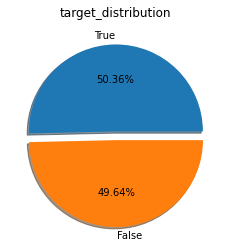

In [7]:
plt.figsize=(10,6)
plt.pie(train_data['Transported'].value_counts(),explode=[0,0.1],
       shadow=True,autopct='%.2f%%',labels=['True','False'])
plt.title("target_distribution")
plt.show()

- 언더샘플링이나 오버샘플링이 되어있지 않음

#### features 들을 분석하여보자

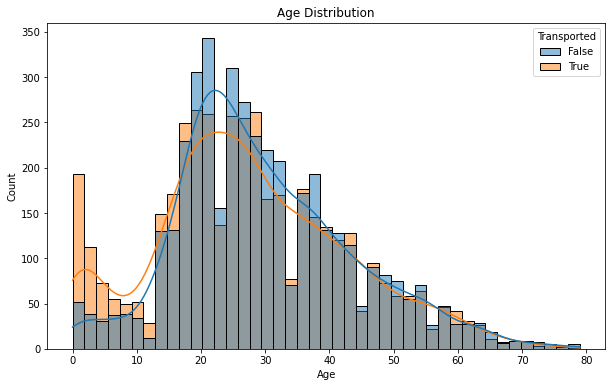

In [8]:
plt.figure(figsize=(10,6))
sns.histplot(data=train_data,x='Age',hue='Transported',kde=True)
plt.title('Age Distribution')
plt.show()


- 0~18세 까지는 비행기에 탑승한 사람이 더 많다.
- 18~25세 까지는 비행기에 탑승하지 못한 사람이 더 많다 
- 25세 이상은 그리 특별하진 않고 비슷 또는 동등하다

- 그리하여 0~18(child) , 18~25(adolecent) , 25~(adult) 로 새로운 변수를 만들어 줄 수 있게 된다.

### 비용 변수

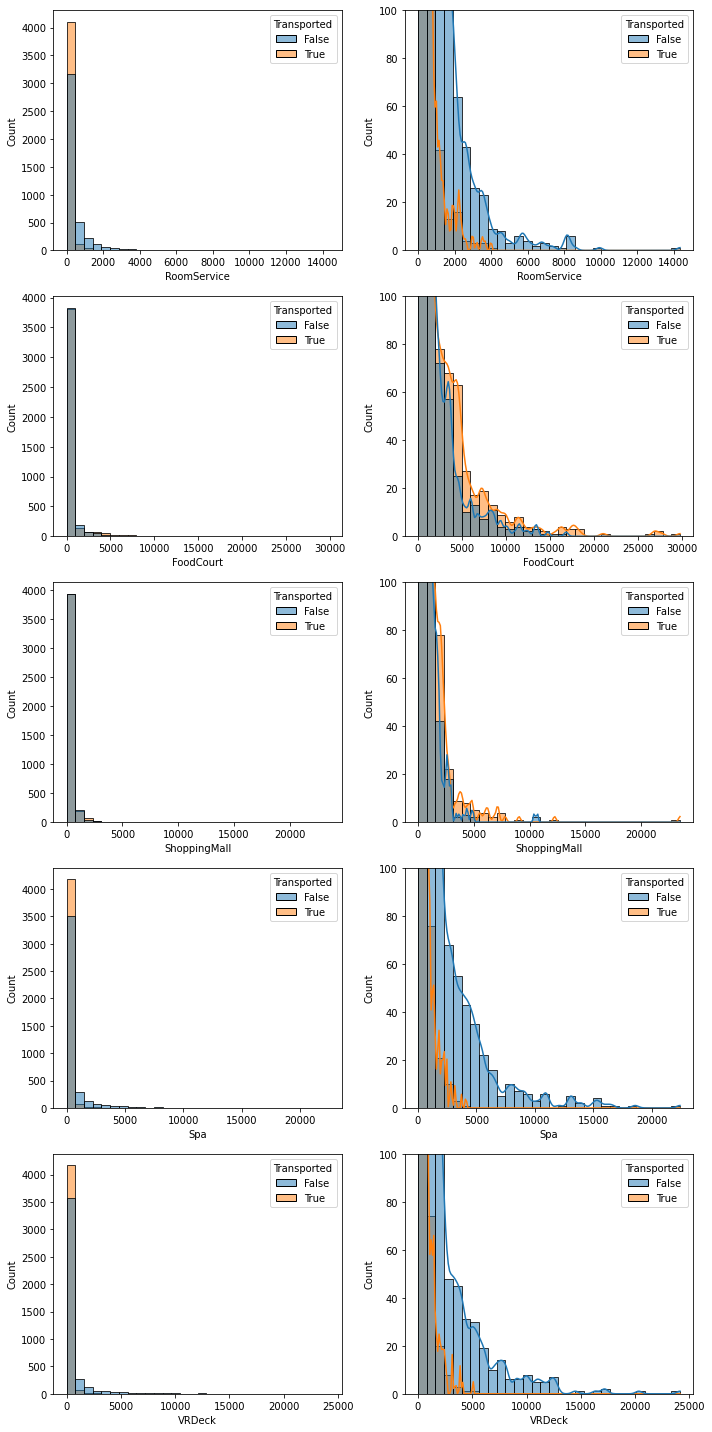

In [9]:
exp_features=['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
fig = plt.figure(figsize = (10, 20))
for i, col in enumerate(exp_features):
    #왼쪽 그래프
    ax=fig.add_subplot(5,2,2*i+1) # 3번쨰 파라미터는 index 이다.
    sns.histplot(data=train_data,x=col,bins=30,hue='Transported',ax=ax)
    #오른쪽 그래프 
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train_data,x=col,bins=30,hue='Transported',kde=True,ax=ax)
    plt.ylim([0,100])  # count 의 범위를 낮춤으로써, 변화를 급격하게 보여준다
fig.tight_layout()
plt.show()

- 대부분의 사람들은 돈을 쓰지 않았다
- 탑승을 한 사람들은 대부분 돈을 적게썼다.
- roomservice,vrdeck,spa(팁승하지 못한 사람 많음)  vs shoppingmall,foodcourt(탑승한 사람 많음) -> 고가 부대시설을 즐긴 사람 vs 그렇지 않은 사람

- 5개 편의시설 전체에 총 지출을 추적하는 feature 생성가능
- 돈을 쓴 사람과 쓰지 않은 사람을 나누는 feature 생성가능

### 범주형 변수.


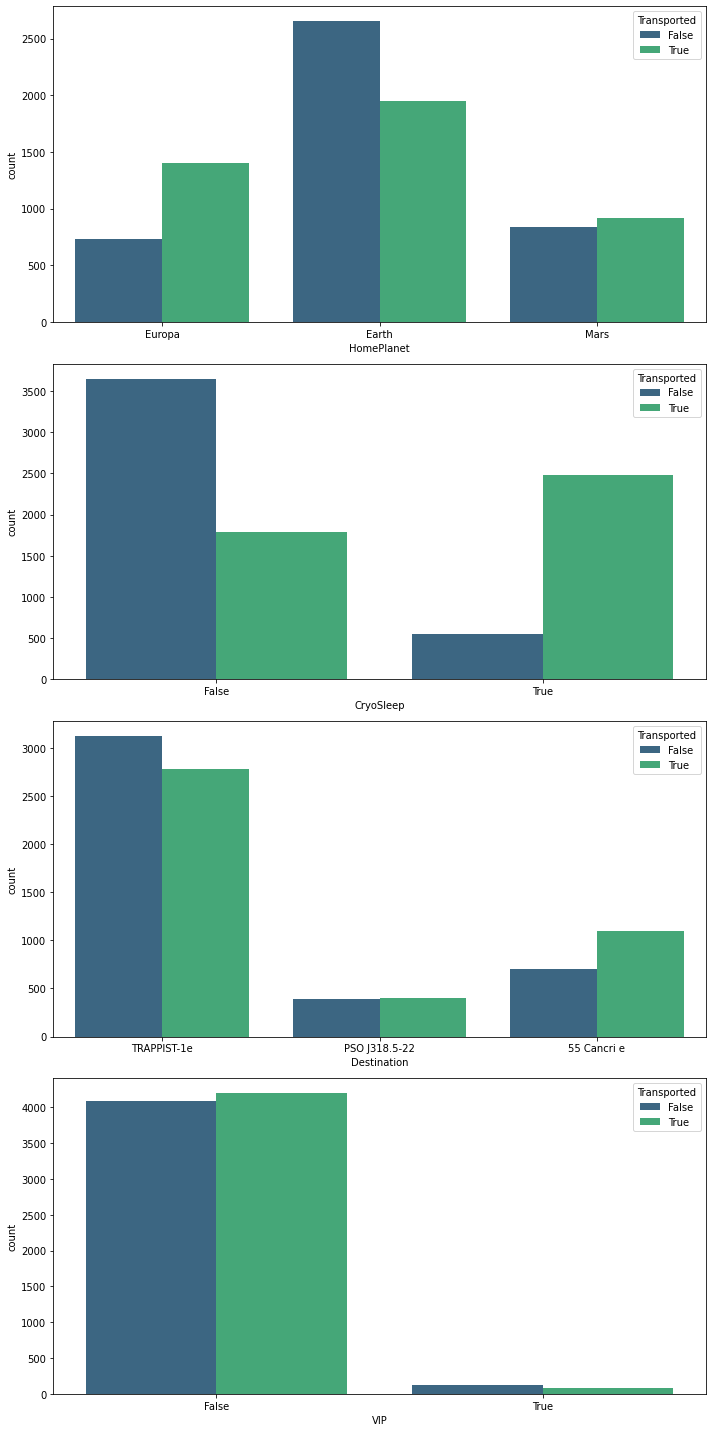

In [10]:
features=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
fig=plt.figure(figsize=(10,20))
for i,col in enumerate(features):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train_data,x=col,hue='Transported',ax=ax,palette='viridis')

fig.tight_layout()
plt.show()

- vip 변수는 transported true,false 비율이 비슷하기 떄문에 drop 시킨다
- cryosleep 변수가 대조적으로 굉장히 큰 차이를 준다.

### age 결측치 제거

- 중앙값으로 결측치를 채워준다

In [11]:
train_data['Age'].isnull().sum() # age의 결측치 179개

179

In [12]:

train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
test_data['Age'].fillna(train_data['Age'].median(), inplace=True) # 데이터누수가 일어나지 않게 , test_data 도 똑같이 !!
train_data['Age'].isnull().sum()


0

#### 질적변수

In [13]:
qual_features=['PassengerId', 'Cabin' ,'Name']
train_data[qual_features].head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


- passengerid 는 111_00 형태로 이루어져 잇는데 앞 부분 111 은 함께 이동하는 그룹을 의미한다
 + 
- cabin의 형태는 갑판/번호/측면이며, 좌현에서는 p,우현에서는 s중 하나가 될 수 있습니다 
 + cabin 각각의 의미를 가지니까 갑판/번호/측면 으로 나누어 줄 수 있다.

#### categorical data
- 결측치 처리 해주기 위해서, mode() 로 최빈값을 보여준다

In [14]:
train_data[['HomePlanet','CryoSleep','Destination','VIP']].mode()

,HomePlanet,CryoSleep,Destination,VIP
0,Earth,False,TRAPPIST-1e,False


- 결측치 값들은 최빈값으로 대체 시켜주는 전처리

In [15]:
train_data['HomePlanet'].fillna('Earth', inplace=True)
test_data['HomePlanet'].fillna('Earth', inplace=True)

train_data['CryoSleep'].fillna(False, inplace=True)
test_data['CryoSleep'].fillna(False, inplace=True)

train_data['Destination'].fillna('TRAPPIST-1e', inplace=True)
test_data['Destination'].fillna('TRAPPIST-1e', inplace=True)

train_data['VIP'].fillna(False, inplace=True)
test_data['VIP'].fillna(False, inplace=True)



In [16]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


#### 파생변수

#### 아까  위에 말했던, 비용에 대한 값을 다 총합을 시켜주고 비용을 쓰지 않은 사람과 구분해 준다

In [17]:
# 비용을 아예 쓰지 않은 사람 구분 해주고 모든 비용들을 합쳐준다
train_data['Expenditure']=train_data[exp_features].sum(axis=1)
train_data['No_spending']=(train_data['Expenditure']==0).astype(int)

test_data['Expenditure']=test_data[exp_features].sum(axis=1)
test_data['No_spending']=(test_data['Expenditure']==0).astype(int)



In [18]:
# exp_features 에도, 최빈값인 0을 넣어줍니다
for col in exp_features:
    train_data.loc[train_data[col].isna(),col]=0
    test_data.loc[test_data[col].isna(),col]=0

In [19]:
#
train_data['Cabin'].fillna('Z/9999/Z', inplace=True)
test_data['Cabin'].fillna('Z/9999/Z', inplace=True)

train_data['Name'].fillna('No Name', inplace=True)
test_data['Name'].fillna('No Name', inplace=True)

### 파생변수

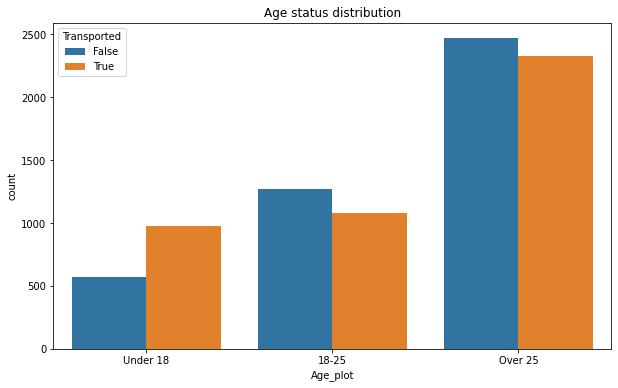

In [20]:
#위에서 언급했던 나이대별로 타겟값이 차이를 보이기때문에, 나이별로 묶어주어, 과적합 방지

train_data['Under_18']=(train_data['Age']<18).astype(int)
train_data['18_to_25']=((train_data['Age']>=18) & (train_data['Age']<=25)).astype(int)
train_data['Over_25']=(train_data['Age']>25).astype(int)

test_data['Under_18']=(test_data['Age']<18).astype(int)
test_data['18_to_25']=((test_data['Age']>=18) & (test_data['Age']<=25)).astype(int)
test_data['Over_25']=(test_data['Age']>25).astype(int)

train_data['Age_plot']=train_data['Under_18']+2*train_data['18_to_25']+3*train_data['Over_25']
plt.figure(figsize=(10, 6))
g=sns.countplot(data=train_data, x='Age_plot', hue='Transported')
plt.title('Age status distribution')
g.set_xticklabels(['Under 18', '18-25', 'Over 25'])
train_data.drop('Age_plot', axis=1, inplace=True)


#### 비용에대한 파생변수

- 비용을 지출한 사람은 비용의 총합이라는 feature 를 만들어주고
- 비용을 지출하지 않은사람들은 따로 떼어준다.

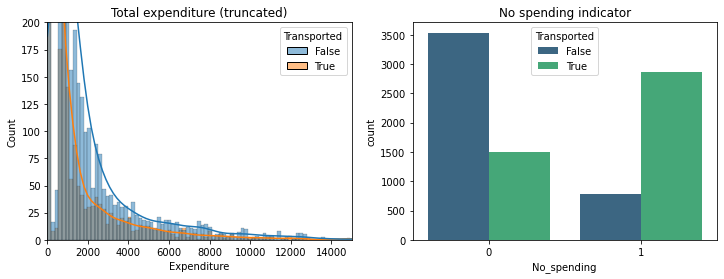

In [21]:

train_data['Expenditure']=train_data[exp_features].sum(axis=1)
train_data['No_spending']=(train_data['Expenditure']==0).astype(int)

# New features - test set
test_data['Expenditure']=test_data[exp_features].sum(axis=1)
test_data['No_spending']=(test_data['Expenditure']==0).astype(int)

# Plot distribution of new features
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=train_data, x='Expenditure', hue='Transported', kde = True, bins=200)
plt.title('Total expenditure (truncated)')
plt.ylim([0,200])
plt.xlim([0,15000])

plt.subplot(1,2,2)
sns.countplot(data=train_data, x='No_spending', hue='Transported', palette = 'viridis')
plt.title('No spending indicator')
plt.show()

- 이 그래프에서도 확연히 볼 수 있듯이  비용을 안 쓴사람은 쓴 사람에 비해 탑승율이 더 높았다


### passenger 는 그룹을 나타내 주기 때문에 그 룹을 나누어 준다. 

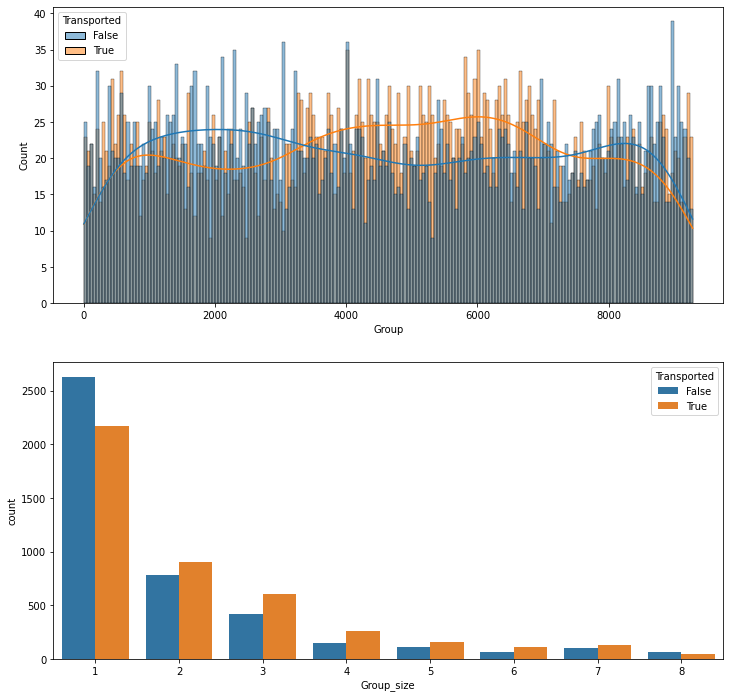

In [22]:
# New features - training set
train_data['Group'] = train_data['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
train_data['Group_size']=train_data['Group'].map(lambda x: train_data['Group'].value_counts()[x])

# New features - test set
test_data['Group'] = test_data['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test_data['Group_size']=test_data['Group'].map(lambda x: test_data['Group'].value_counts()[x])

# Plot distribution of new features
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.histplot(data=train_data, x='Group', hue='Transported', bins = 200, kde = True)

plt.subplot(2,1,2)
sns.countplot(data=train_data, x='Group_size', hue='Transported')
fig.tight_layout()
plt.show()

- 그룹 지표는 종류가 너무 많기 떄문에 인코딩 불가
- 반면 group_size 는 solo 로 온 사람을 색출 할 수 있기 떄문에 유용하다.

(0.0, 3000.0)

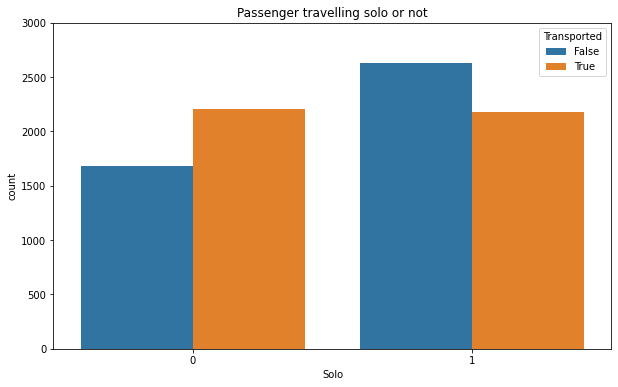

In [23]:
# New feature
train_data['Solo']=(train_data['Group_size']==1).astype(int)
test_data['Solo']=(test_data['Group_size']==1).astype(int)

# New feature distribution
plt.figure(figsize=(10,6))
sns.countplot(data=train_data, x='Solo', hue='Transported')
plt.title('Passenger travelling solo or not')
plt.ylim([0,3000])

- 그룹으로 가지 않은 사람들은 탑승했을가능성이 크고 , 솔로로 간 사람들은 탑승하지 못했을 가능성이 크다

#### cabin의 위치
-cabin deck 의 위치별로 true false 가 명확하게 구분되는 것을 볼 수 있다

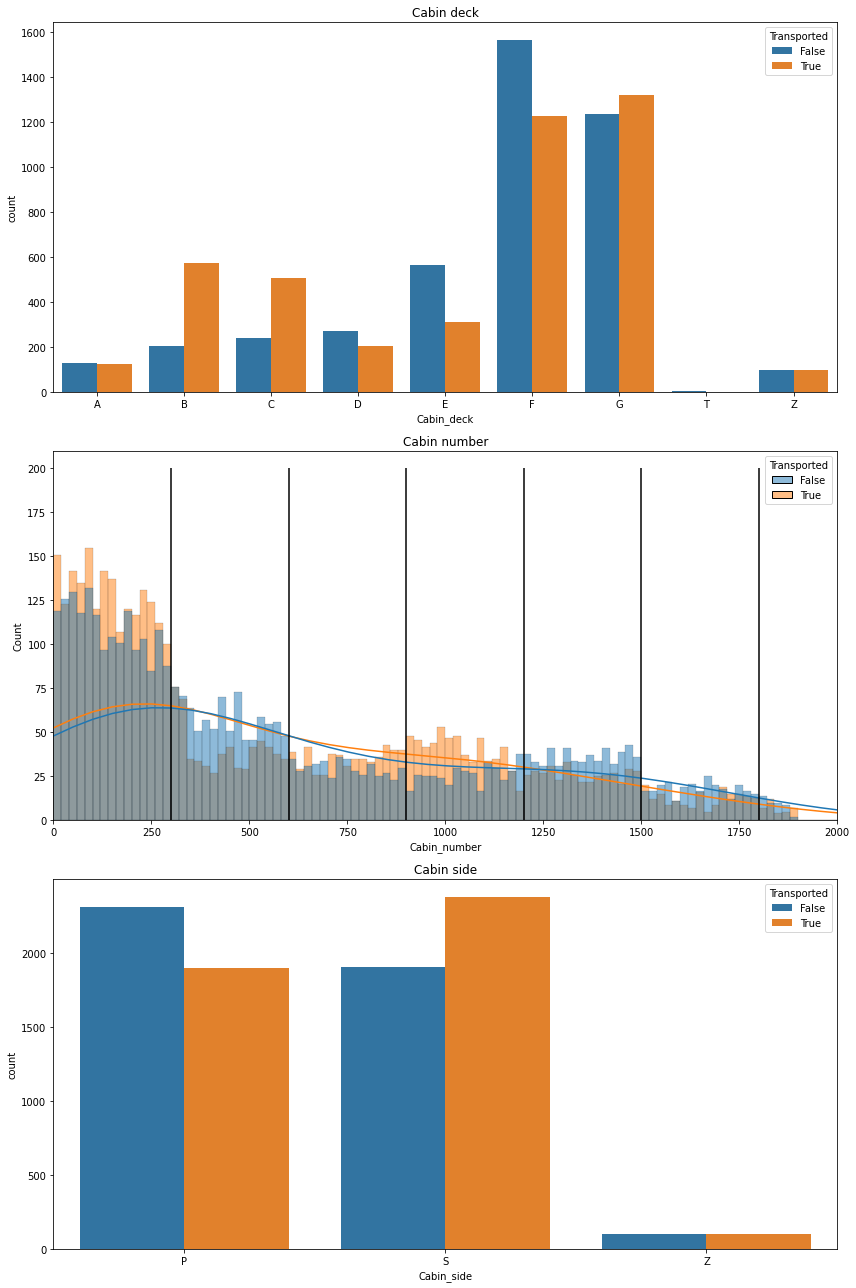

In [24]:
# New features - training set
train_data['Cabin_deck'] = train_data['Cabin'].apply(lambda x: x.split('/')[0])
train_data['Cabin_number'] = train_data['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train_data['Cabin_side'] = train_data['Cabin'].apply(lambda x: x.split('/')[2])

# New features - test set
test_data['Cabin_deck'] = test_data['Cabin'].apply(lambda x: x.split('/')[0])
test_data['Cabin_number'] = test_data['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test_data['Cabin_side'] = test_data['Cabin'].apply(lambda x: x.split('/')[2])

# Plot distribution of new features
fig=plt.figure(figsize=(12,18))
plt.subplot(3,1,1)
sns.countplot(data=train_data, x='Cabin_deck', hue='Transported', order=['A','B','C','D','E','F','G','T','Z'])
plt.title('Cabin deck')

plt.subplot(3,1,2)
sns.histplot(data=train_data, x='Cabin_number', hue='Transported',binwidth=20, kde = True)
plt.vlines(300, ymin=0, ymax=200, color='black')
plt.vlines(600, ymin=0, ymax=200, color='black')
plt.vlines(900, ymin=0, ymax=200, color='black')
plt.vlines(1200, ymin=0, ymax=200, color='black')
plt.vlines(1500, ymin=0, ymax=200, color='black')
plt.vlines(1800, ymin=0, ymax=200, color='black')
plt.title('Cabin number')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=train_data, x='Cabin_side', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

- cabin number 를 보면 300개의 cabin 을 기준으로 그룹화 되는 것 을 확인 할 수 있다.

#### 위에서 얻은 인사이트로 cabin number 에 따라서 새로운 변수를 생성시켜 주어 보자 !!

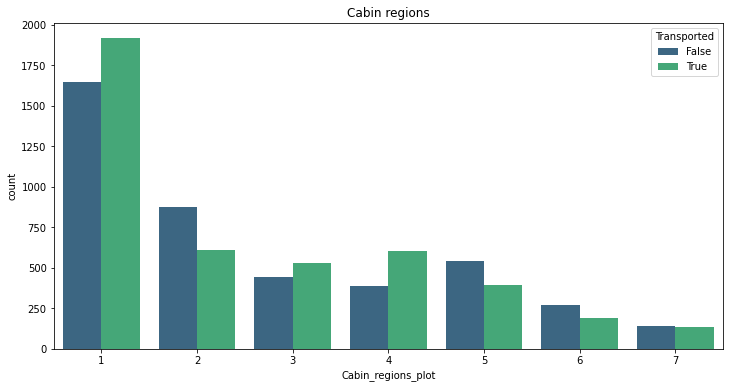

In [25]:


# New features - training set
train_data['Cabin_region1']=(train_data['Cabin_number']<300).astype(int)   # one-hot encoding
train_data['Cabin_region2']=((train_data['Cabin_number']>=300) & (train_data['Cabin_number']<600)).astype(int)
train_data['Cabin_region3']=((train_data['Cabin_number']>=600) & (train_data['Cabin_number']<900)).astype(int)
train_data['Cabin_region4']=((train_data['Cabin_number']>=900) & (train_data['Cabin_number']<1200)).astype(int)
train_data['Cabin_region5']=((train_data['Cabin_number']>=1200) & (train_data['Cabin_number']<1500)).astype(int)
train_data['Cabin_region6']=((train_data['Cabin_number']>=1500) & (train_data['Cabin_number']<1800)).astype(int)
train_data['Cabin_region7']=(train_data['Cabin_number']>=1800).astype(int)

# New features - test set
test_data['Cabin_region1']=(test_data['Cabin_number']<300).astype(int)   # one-hot encoding
test_data['Cabin_region2']=((test_data['Cabin_number']>=300) & (test_data['Cabin_number']<600)).astype(int)
test_data['Cabin_region3']=((test_data['Cabin_number']>=600) & (test_data['Cabin_number']<900)).astype(int)
test_data['Cabin_region4']=((test_data['Cabin_number']>=900) & (test_data['Cabin_number']<1200)).astype(int)
test_data['Cabin_region5']=((test_data['Cabin_number']>=1200) & (test_data['Cabin_number']<1500)).astype(int)
test_data['Cabin_region6']=((test_data['Cabin_number']>=1500) & (test_data['Cabin_number']<1800)).astype(int)
test_data['Cabin_region7']=(test_data['Cabin_number']>=1800).astype(int)

# Plot distribution of new features
plt.figure(figsize=(12,6))
train_data['Cabin_regions_plot']=(train_data['Cabin_region1']+2*train_data['Cabin_region2']+3*train_data['Cabin_region3']+4*train_data['Cabin_region4']+5*train_data['Cabin_region5']+6*train_data['Cabin_region6']+7*train_data['Cabin_region7']).astype(int)
sns.countplot(data=train_data, x='Cabin_regions_plot', hue='Transported', palette = 'viridis')
plt.title('Cabin regions')
train_data.drop('Cabin_regions_plot', axis=1, inplace=True)

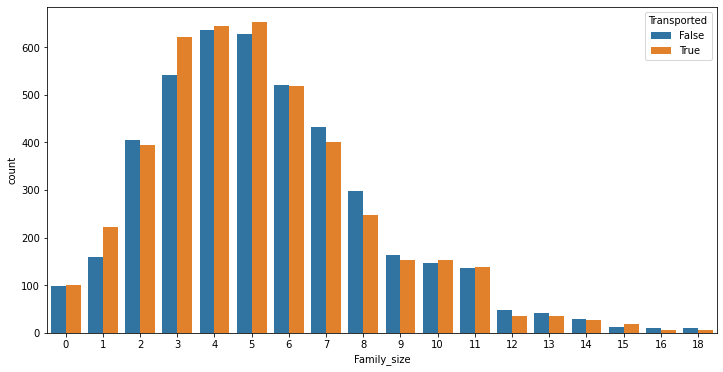

In [26]:
# New features - training set
train_data['Surname']=train_data['Name'].str.split().str[-1]
train_data['Family_size']=train_data['Surname'].map(lambda x: train_data['Surname'].value_counts()[x])

# New features - test set
test_data['Surname']=test_data['Name'].str.split().str[-1]
test_data['Family_size']=test_data['Surname'].map(lambda x: test_data['Surname'].value_counts()[x])

# Set outliers (no name) to have no family
train_data.loc[train_data['Family_size']==200,'Family_size']=0
test_data.loc[test_data['Family_size']==200,'Family_size']=0

# New feature distribution
plt.figure(figsize=(12,6))
sns.countplot(data=train_data, x='Family_size', hue='Transported')
plt.show()

### 불필요한 변수 제거

In [27]:
# Drop qualitative/redundant/high cardinality features
train_data.drop(['PassengerId', 'Cabin', 'Name', 'Surname', 'VIP', 'Group', 'Cabin_number'], axis=1, inplace=True)
test_data.drop(['PassengerId', 'Cabin', 'Name', 'Surname', 'VIP', 'Group', 'Cabin_number'], axis=1, inplace=True)

# Preview resulting training set
train_data.head()

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,...,Cabin_deck,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Family_size
0,Europa,False,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,False,...,B,P,1,0,0,0,0,0,0,1
1,Earth,False,TRAPPIST-1e,24.0,109.0,9.0,25.0,549.0,44.0,True,...,F,S,1,0,0,0,0,0,0,4
2,Europa,False,TRAPPIST-1e,58.0,43.0,3576.0,0.0,6715.0,49.0,False,...,A,S,1,0,0,0,0,0,0,6
3,Europa,False,TRAPPIST-1e,33.0,0.0,1283.0,371.0,3329.0,193.0,False,...,A,S,1,0,0,0,0,0,0,6
4,Earth,False,TRAPPIST-1e,16.0,303.0,70.0,151.0,565.0,2.0,True,...,F,S,1,0,0,0,0,0,0,6


In [28]:
print(train_data.isnull().sum())
print(test_data.isnull().sum())

HomePlanet       0
CryoSleep        0
Destination      0
Age              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Transported      0
Expenditure      0
No_spending      0
Under_18         0
18_to_25         0
Over_25          0
Group_size       0
Solo             0
Cabin_deck       0
Cabin_side       0
Cabin_region1    0
Cabin_region2    0
Cabin_region3    0
Cabin_region4    0
Cabin_region5    0
Cabin_region6    0
Cabin_region7    0
Family_size      0
dtype: int64
HomePlanet       0
CryoSleep        0
Destination      0
Age              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Expenditure      0
No_spending      0
Under_18         0
18_to_25         0
Over_25          0
Group_size       0
Solo             0
Cabin_deck       0
Cabin_side       0
Cabin_region1    0
Cabin_region2    0
Cabin_region3    0
Cabin_region4    0
Cabin_region5    0
Cabin_region6    0
Cabin_region7    0

- 결측치 제거 완료

In [29]:
# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.utils import resample

## 범주형 변수 인코딩 

Lables (정답) 생성

In [30]:
y=train_data['Transported'].copy().astype(int) # label생성 이것 또한 인코딩이 된 것
X=train_data.drop('Transported', axis=1).copy() # label 을 drop 시킨 데이터 생성
X_test_data=test_data.copy() # X_test_data 에는  test_data 를 copy 해준다
X_test_data.shape
print(X.shape)
X_test_data.head(40)




(8693, 26)


,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Expenditure,...,Cabin_deck,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Family_size
0,Earth,True,TRAPPIST-1e,27.0,0.0,0.0,0.0,0.0,0.0,0.0,...,G,S,1,0,0,0,0,0,0,4
1,Earth,False,TRAPPIST-1e,19.0,0.0,9.0,0.0,2823.0,0.0,2832.0,...,F,S,1,0,0,0,0,0,0,1
2,Europa,True,55 Cancri e,31.0,0.0,0.0,0.0,0.0,0.0,0.0,...,C,S,1,0,0,0,0,0,0,1
3,Europa,False,TRAPPIST-1e,38.0,0.0,6652.0,0.0,181.0,585.0,7418.0,...,C,S,1,0,0,0,0,0,0,1
4,Earth,False,TRAPPIST-1e,20.0,10.0,0.0,635.0,0.0,0.0,645.0,...,F,S,1,0,0,0,0,0,0,3
5,Earth,False,TRAPPIST-1e,31.0,0.0,1615.0,263.0,113.0,60.0,2051.0,...,F,P,1,0,0,0,0,0,0,4
6,Europa,True,55 Cancri e,21.0,0.0,0.0,0.0,0.0,0.0,0.0,...,B,P,1,0,0,0,0,0,0,1
7,Europa,True,TRAPPIST-1e,20.0,0.0,0.0,0.0,0.0,0.0,0.0,...,D,S,1,0,0,0,0,0,0,2
8,Europa,True,55 Cancri e,23.0,0.0,0.0,0.0,0.0,0.0,0.0,...,D,S,1,0,0,0,0,0,0,2
9,Earth,False,55 Cancri e,24.0,0.0,639.0,0.0,0.0,0.0,639.0,...,F,S,1,0,0,0,0,0,0,2


### 범주형 변수 인코딩과 스케일링


In [31]:
cat_col=['HomePlanet','CryoSleep','Destination','Cabin_deck','Cabin_side']
pre=train_data[cat_col]

pre_enc=pd.get_dummies(pre)

pre_enc['CryoSleep']=pre_enc['CryoSleep'].map({True:1,False:0})

print(pre_enc.shape)

(8693, 19)


In [32]:

cat_col=['HomePlanet','CryoSleep','Destination','Cabin_deck','Cabin_side']
pre1=test_data[cat_col]

pre_enc1=pd.get_dummies(pre1)

pre_enc1['CryoSleep']=pre_enc1['CryoSleep'].map({True:1,False:0})

print(pre_enc1.shape)




(4277, 19)


In [33]:
print(X.shape)
print(X_test_data.shape)
X.info()
X=X.drop(['HomePlanet','CryoSleep','Destination','Cabin_deck','Cabin_side'],axis=1)
X_test_data=X_test_data.drop(['HomePlanet','CryoSleep','Destination','Cabin_deck','Cabin_side'],axis=1)


(8693, 26)
(4277, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HomePlanet     8693 non-null   object 
 1   CryoSleep      8693 non-null   bool   
 2   Destination    8693 non-null   object 
 3   Age            8693 non-null   float64
 4   RoomService    8693 non-null   float64
 5   FoodCourt      8693 non-null   float64
 6   ShoppingMall   8693 non-null   float64
 7   Spa            8693 non-null   float64
 8   VRDeck         8693 non-null   float64
 9   Expenditure    8693 non-null   float64
 10  No_spending    8693 non-null   int64  
 11  Under_18       8693 non-null   int64  
 12  18_to_25       8693 non-null   int64  
 13  Over_25        8693 non-null   int64  
 14  Group_size     8693 non-null   int64  
 15  Solo           8693 non-null   int64  
 16  Cabin_deck     8693 non-null   object 
 17  Cabin_side     8693 non-null  

In [34]:
print(X.shape)
print(X_test_data.shape)
print(pre_enc.shape)
print(pre_enc1.shape)
X=pd.concat([X,pre_enc],axis=1)
X_test_data=pd.concat([X_test_data,pre_enc1],axis=1)

(8693, 21)
(4277, 21)
(8693, 19)
(4277, 19)


In [35]:
print(X.shape)
print(X_test_data.shape)


(8693, 40)
(4277, 40)


# Step 4. 머신러닝 모형 개발
- 모형에 대한 설명 필요
- 모형을 1-2개 사용
- 교차 검증
- 하이퍼파라미터 튜닝

### 검증데이터를 만들어 준다. 

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((6085, 40), (2608, 40), (6085,), (2608,))

- 이번에는 LightGBM 클래스를 부른 후 모형을 학습한다. 

# 하이퍼파라미터 튜닝
- 랜덤서치 (매개변수, max_depth) / 0.796
- 그리드서치 / 0.791

In [37]:
from lightgbm import LGBMClassifier


lgb = LGBMClassifier(random_state=42,n_estimators=150,max_depth=4,)
lgb

LGBMClassifier(max_depth=4, n_estimators=150, random_state=42)

# Step 5. 모형 평가
- 훈련데이터 쪼갠다. 훈련데이터 + 검증데이터 분리
- 정확도 비교
- 혼동행렬 (Confusion Matrix) 설명

- 먼저 cross_validate() 활용한다. 

In [38]:

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

splitter = StratifiedKFold(n_splits = 5, shuffle = True, random_state=42)
scores = cross_validate(lgb, X_train, y_train, return_train_score = True, cv=splitter)

print("train Acc.", np.mean(scores['train_score']))
print("test Acc.", np.mean(scores['test_score']))

train Acc. 0.8647082990961381
test Acc. 0.8138044371405094


- 이번에는 검증 데이터를 활용하여 정확도를 예상해본다. 

In [39]:

from sklearn.metrics import accuracy_score

lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_val)
print("Acc.", accuracy_score(y_val, y_pred))

## confusion matrix





Acc. 0.8090490797546013


# Step 6. 제출
- 제출 양식은 샘플 만들어드림

In [40]:
test_preds = lgb.predict(X_test_data.to_numpy())
sample_submission['Transported'] = test_preds.astype("bool")
sample_submission.to_csv("submission.csv",index=False)
sample_submission.head()

print(test_preds.shape)
print(X_val.shape)
print(X_test_data.shape)



(4277,)
(2608, 40)
(4277, 40)


# 혼동행렬

[[1015  274]
 [ 224 1095]]


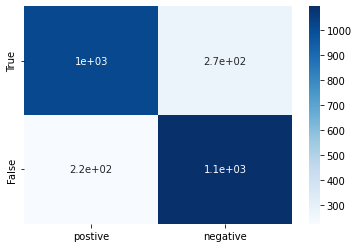

In [41]:
import sklearn.metrics as metrics

cm=metrics.confusion_matrix(y_val,y_pred)
print(cm)


sns.heatmap(cm, annot=True, cmap='Blues',
           xticklabels=['postive', 'negative'],       # 예측
           yticklabels=['True', 'False'])               # 실제
plt.show()




# 정밀도
- 'True' 으로 예측했을때 실제도 'True' 인 비율

In [42]:
# 72/(72+1)
p = metrics.precision_score(y_val, y_pred)
p




0.799853907962016

# 재현율
- 실제로 True 를 True 로 예측한 비율

In [43]:
r = metrics.recall_score(y_val, y_pred)
r


0.8301743745261562

# F1 score 
- 정밀도와 재현율의 조화평균

In [44]:
metrics.f1_score(y_val, y_pred)



0.8147321428571429

# 곡선하 면정, 민감도 또는 1- 특이성 그래프 

- 참 긍정율과 거짓 부정률 사이를 표현하기 위해 사용

<AxesSubplot:xlabel='FPR', ylabel='TPR'>

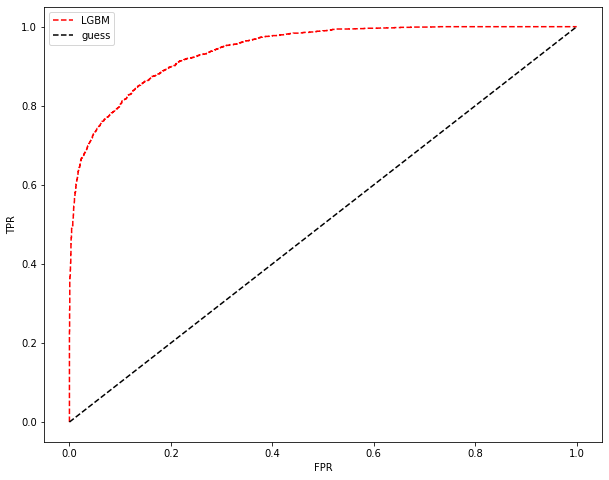

In [45]:
proba=lgb.predict_proba(X_train)
fig,ax=plt.subplots(figsize=(10,8))
fpr, tpr, thressholds = metrics.roc_curve(y_train, proba[:,1])
ax.plot(fpr,tpr,'r--',label='LGBM')
ax.plot([0, 1],[0, 1], 'k--', label='guess')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.legend()
ax








